In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.optim import Adam
from src.core.trainer import Trainer
from src.utils.data import ParallelInfiniteDataLoader
from src.dataset import StandardDataset, CombinedDataset
from src.core.config import Config
from src.core.model_config import ModelConfig
from src.network import Model, TestModel
from src.utils.optimizer import SophiaG
from src.utils.callbacks import ModelCheckpoint
from src.utils.layers import Conv2d, LDConv2d, CDConv2d
from src.utils.transform import *
import torchvision.transforms as t

import random
import numpy as np
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(Config.SEED + 256) ## Give different data during validating in training
random.seed(Config.SEED + 256)
np.random.seed(Config.SEED + 256)




CHECKPOINT_PATH = r'validation_weight\MetaSGD_model_epoch=19200_epoch_acc=0.79_best_k=1.pth'
BASE_CHECKPOINT_PATH = r'validation_weight\baseline_model_epoch=18800_test_acc=0.8885_best_k=1.pth'

ModelConfig.IN_CHANNELS = 3
model = TestModel(ModelConfig, conv_type = LDConv2d)
ckpt = torch.load(CHECKPOINT_PATH, map_location= 'cpu')
model.load_state_dict(ckpt["model_checkpoint"])
model = model.cuda()
model.eval();

model_base = TestModel(ModelConfig, conv_type = LDConv2d)
ckpt = torch.load(BASE_CHECKPOINT_PATH, map_location= 'cpu')
model_base.load_state_dict(ckpt["model_checkpoint"])
model_base = model_base.cuda()
model_base.eval();


train_data_settings = {'get_real': None, 
                       'get_hsv': False if ModelConfig.IN_CHANNELS == 3 else True}
ds3 = StandardDataset('data/zalo_data', transform = t.Compose([ToTensor()]), **train_data_settings)

# smplr3 = WeightedRandomSampler(ds3.get_weight(), len(ds3))
# dl3 = DataLoader(ds3, batch_size= Config.BATCH_SIZE, sampler = smplr3)

weight = np.array(ds3.get_weight())
weight /= weight.sum()
indices_list = np.random.choice(list(range(len(ds3))), Config.BATCH_SIZE * 100, False,weight)
ds3 = torch.utils.data.Subset(ds3, indices_list)
dl3 = DataLoader(ds3, batch_size= Config.BATCH_SIZE)

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# [model.net.lastconv1[0]]

cam = GradCAM(model=model, target_layers=[model.meta_leaner.net[1],model.meta_leaner.net[4], 
                                          model.featex.nets.Block3[0], model.featex.nets.Block3[3], model.featex.nets.Block3[6],
                                        #   model.featex.nets.Block2[0], model.featex.nets.Block2[3], model.featex.nets.Block2[6],
                                        #   model.featex.nets.Block1[0], model.featex.nets.Block1[3], model.featex.nets.Block1[6]
                                          ], use_cuda=True)

cam_base = GradCAM(model=model_base, target_layers=[model_base.meta_leaner.net[1],model_base.meta_leaner.net[4], 
                                          model_base.featex.nets.Block3[0], model_base.featex.nets.Block3[3], model_base.featex.nets.Block3[6],
                                        #   model_base.featex.nets.Block2[0], model_base.featex.nets.Block2[3], model_base.featex.nets.Block2[6],
                                        #   model_base.featex.nets.Block1[0], model_base.featex.nets.Block1[3], model_base.featex.nets.Block1[6]
                                          ], use_cuda=True)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\neptune\common\warnings.py:62: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\neptune\common\warnings.py:62: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  warnings.warn(


Index: 258
True label:  0.0
Predicted score: 0.107


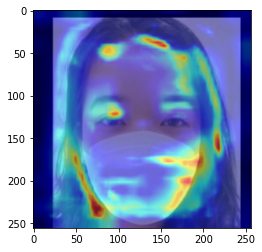

Predicted score: 0.342


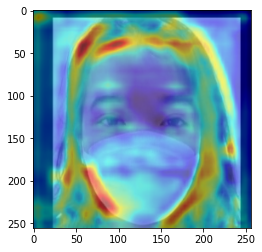

In [385]:
idx = np.random.randint(0,len(ds3))

# idx = 584
print("Index:", idx)
in_tensor = ds3[idx][0]

in_image = in_tensor.permute(1,2,0).numpy()
targets = [ClassifierOutputTarget(ds3[idx][2].long())]
print('True label: ',ds3[idx][2].item())


pred = model(in_tensor.unsqueeze(0).cuda()).cpu().detach()
pred = pred.exp() / pred.exp().sum()
print('Predicted score:', round(pred[0][1].item(),3))

grayscale_cam_net = cam(input_tensor=in_tensor.unsqueeze(0).cuda(), targets=targets)


import matplotlib.pyplot as plt
plt.imshow(show_cam_on_image(in_image,np.transpose(grayscale_cam_net,(1,2,0)),use_rgb= True))
plt.show()




pred_base = model_base(in_tensor.unsqueeze(0).cuda()).cpu().detach()
pred_base = pred_base.exp() / pred_base.exp().sum()
print('Predicted score:', round(pred_base[0][1].item(),3))
grayscale_cam_base_net = cam_base(input_tensor=in_tensor.unsqueeze(0).cuda(), targets=targets)



plt.imshow(show_cam_on_image(in_image,np.transpose(grayscale_cam_base_net,(1,2,0)),use_rgb= True))
plt.show()


In [363]:
zero_to_one = [584, 238, 260, 412] #0 to 1

one_to_zero = [479, 299, 320, 190] #1 to 0

blur = [232] # ảnh mờ, lỗi xử lý dữ liệu

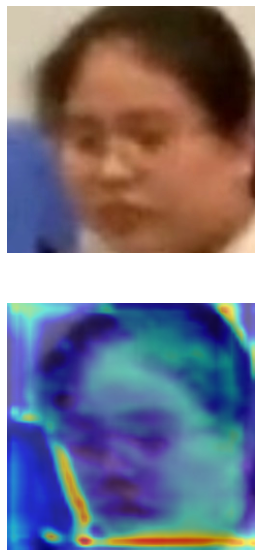

In [368]:
idx_list = blur

fig, ax = plt.subplots(2, len(idx_list), figsize = (20,10), squeeze= False)

for step, idx in enumerate(idx_list):
    in_tensor = ds3[idx][0]
    in_image = in_tensor.permute(1,2,0).numpy()
    targets = [ClassifierOutputTarget(ds3[idx][2].long())]

    pred = model(in_tensor.unsqueeze(0).cuda()).cpu().detach()
    pred = pred.exp() / pred.exp().sum()
    grayscale_cam_net = cam(input_tensor=in_tensor.unsqueeze(0).cuda(), targets=targets)

    # pred_base = model_base(in_tensor.unsqueeze(0).cuda()).cpu().detach()
    # pred_base = pred_base.exp() / pred_base.exp().sum()
    # grayscale_cam_base_net = cam_base(input_tensor=in_tensor.unsqueeze(0).cuda(), targets=targets)


    ax[0,step].imshow(in_image)
    ax[0,step].axis("off")
    # ax[step,1].imshow(show_cam_on_image(in_image,np.transpose(grayscale_cam_base_net,(1,2,0)),use_rgb= True))
    # ax[step,1].axis("off")
    ax[1,step].imshow(show_cam_on_image(in_image,np.transpose(grayscale_cam_net,(1,2,0)),use_rgb= True))
    ax[1,step].axis("off")

fig.show()

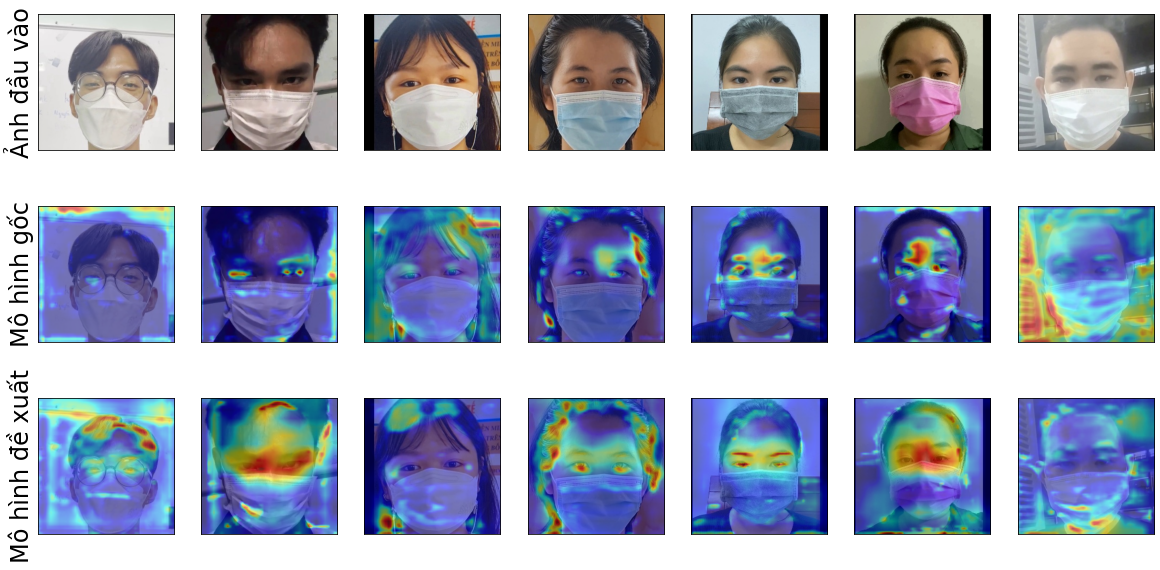

In [397]:
idx_list = [193, 544, 155, 568, 463, 36, 146]

fig, ax = plt.subplots(3, len(idx_list), figsize = (20,10))

FONTSIZE = 24

ax[0,0].set_ylabel('Ảnh đầu vào', fontsize = FONTSIZE)
ax[1,0].set_ylabel('Mô hình gốc', fontsize = FONTSIZE)
ax[2,0].set_ylabel('Mô hình đề xuất', fontsize = FONTSIZE)


for step, idx in enumerate(idx_list):
    in_tensor = ds3[idx][0]
    in_image = in_tensor.permute(1,2,0).numpy()
    targets = [ClassifierOutputTarget(ds3[idx][2].long())]

    pred = model(in_tensor.unsqueeze(0).cuda()).cpu().detach()
    pred = pred.exp() / pred.exp().sum()
    grayscale_cam_net = cam(input_tensor=in_tensor.unsqueeze(0).cuda(), targets=targets)

    pred_base = model_base(in_tensor.unsqueeze(0).cuda()).cpu().detach()
    pred_base = pred_base.exp() / pred_base.exp().sum()
    grayscale_cam_base_net = cam_base(input_tensor=in_tensor.unsqueeze(0).cuda(), targets=targets)


    ax[0, step].imshow(in_image)
    # ax[0, step].axis("off")
    ax[0, step].set_xticks([])
    ax[0, step].set_yticks([])
    ax[0, step].set_facecolor("white")

    ax[1, step].imshow(show_cam_on_image(in_image,np.transpose(grayscale_cam_base_net,(1,2,0)),use_rgb= True))
    # ax[1, step].axis("off")
    ax[1, step].set_yticks([])
    ax[1, step].set_xticks([])
    ax[1, step].set_facecolor("white")

    ax[2, step].imshow(show_cam_on_image(in_image,np.transpose(grayscale_cam_net,(1,2,0)),use_rgb= True))
    # ax[2, step].axis("off")
    ax[2, step].set_yticks([])
    ax[2, step].set_xticks([])
    ax[2, step].set_facecolor("white")

fig.show()